<a href="https://colab.research.google.com/github/dominiksakic/NETworkingMay/blob/main/16_heatmaps_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Why did the network think it contained x?
- Where is x located in the pic?
 - All this we will do in this notebook!

In [1]:
!pip install Pillow -q

Array of img:  (1, 299, 299, 3)


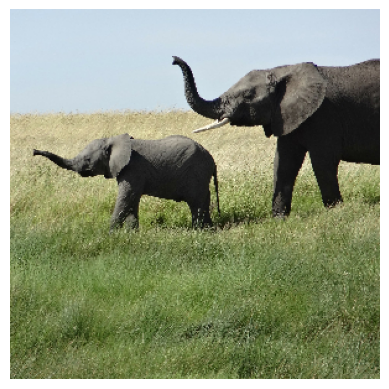

In [6]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load modal and picture.
model = keras.applications.xception.Xception(weights="imagenet")

img_path = keras.utils.get_file(
    fname = "elephant.jpg",
    origin = "https://img-datasets.s3.amazonaws.com/elephant.jpg"
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    # scales pixel between [-1, 1]
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))


# Display picture
# rescales values from the range [-1.0, 1.0] to [0.0, 1.0]. then [0.0, 255.0]
img_rescaled = ((img_array + 1.0) / 2.0) * 255
plt.axis("off")
plt.imshow(img_rescaled[0].astype("uint8"))
plt.show()

In [ ]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])
np.argmax(preds[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[('n02504458', 'African_elephant', np.float32(0.8699399)), ('n01871265', 'tusker', np.float32(0.0769561)), ('n02504013', 'Indian_elephant', np.float32(0.023541728))]


np.int64(386)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_536']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


🔍 Shape of last conv layer output: (1, 10, 10, 2048)


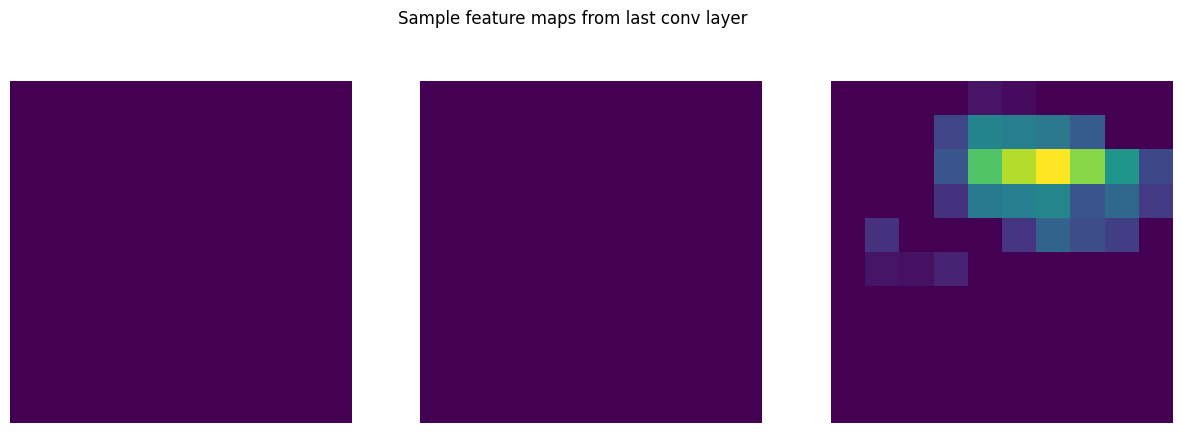

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 10, 10, 2048)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     2,049,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049,000 (7.82 MB)

 Trainable params: 2,049,000 (7.82 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# 1. set up Grad-CAM: maps the input image to the activations of the last conv layer.
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
  "avg_pool",
  "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)


# Example for 1.
feature_maps = last_conv_layer_model(img_array)
print("🔍 Shape of last conv layer output:", feature_maps.shape)

# Plot feature maps (just a few for sanity)
n = 3  # number of filters
plt.figure(figsize=(15, 5))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle("Sample feature maps from last conv layer")
plt.show()

# 2. create a model: maps activations of  last convlayer to the final class preds
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
  x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

classifier_model.summary()




np.float32(3.2733307e-05)

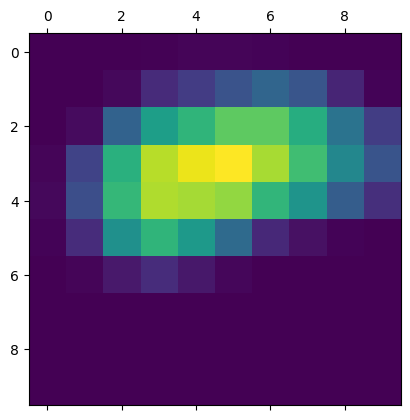

In [25]:
import tensorflow as tf

"""
grads: Measuring how excited each neuron was for "top one predicted class"
pooled_grads: Figuring out which of those neurons were most helpful overall
last_conv_layer_output: visual data the model used
Weighting & Averaging: Combining the visual data with what mattered most -> heatmap
"""


# compute gradients of the top predicted class
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  tape.watch(last_conv_layer_output)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)


# apply pooling and importance weighting to the gradient tensor
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()  # How important was each filter overall?
last_conv_layer_output = last_conv_layer_output.numpy()[0] # actual img
for i in range(pooled_grads.shape[-1]):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)



# display Heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

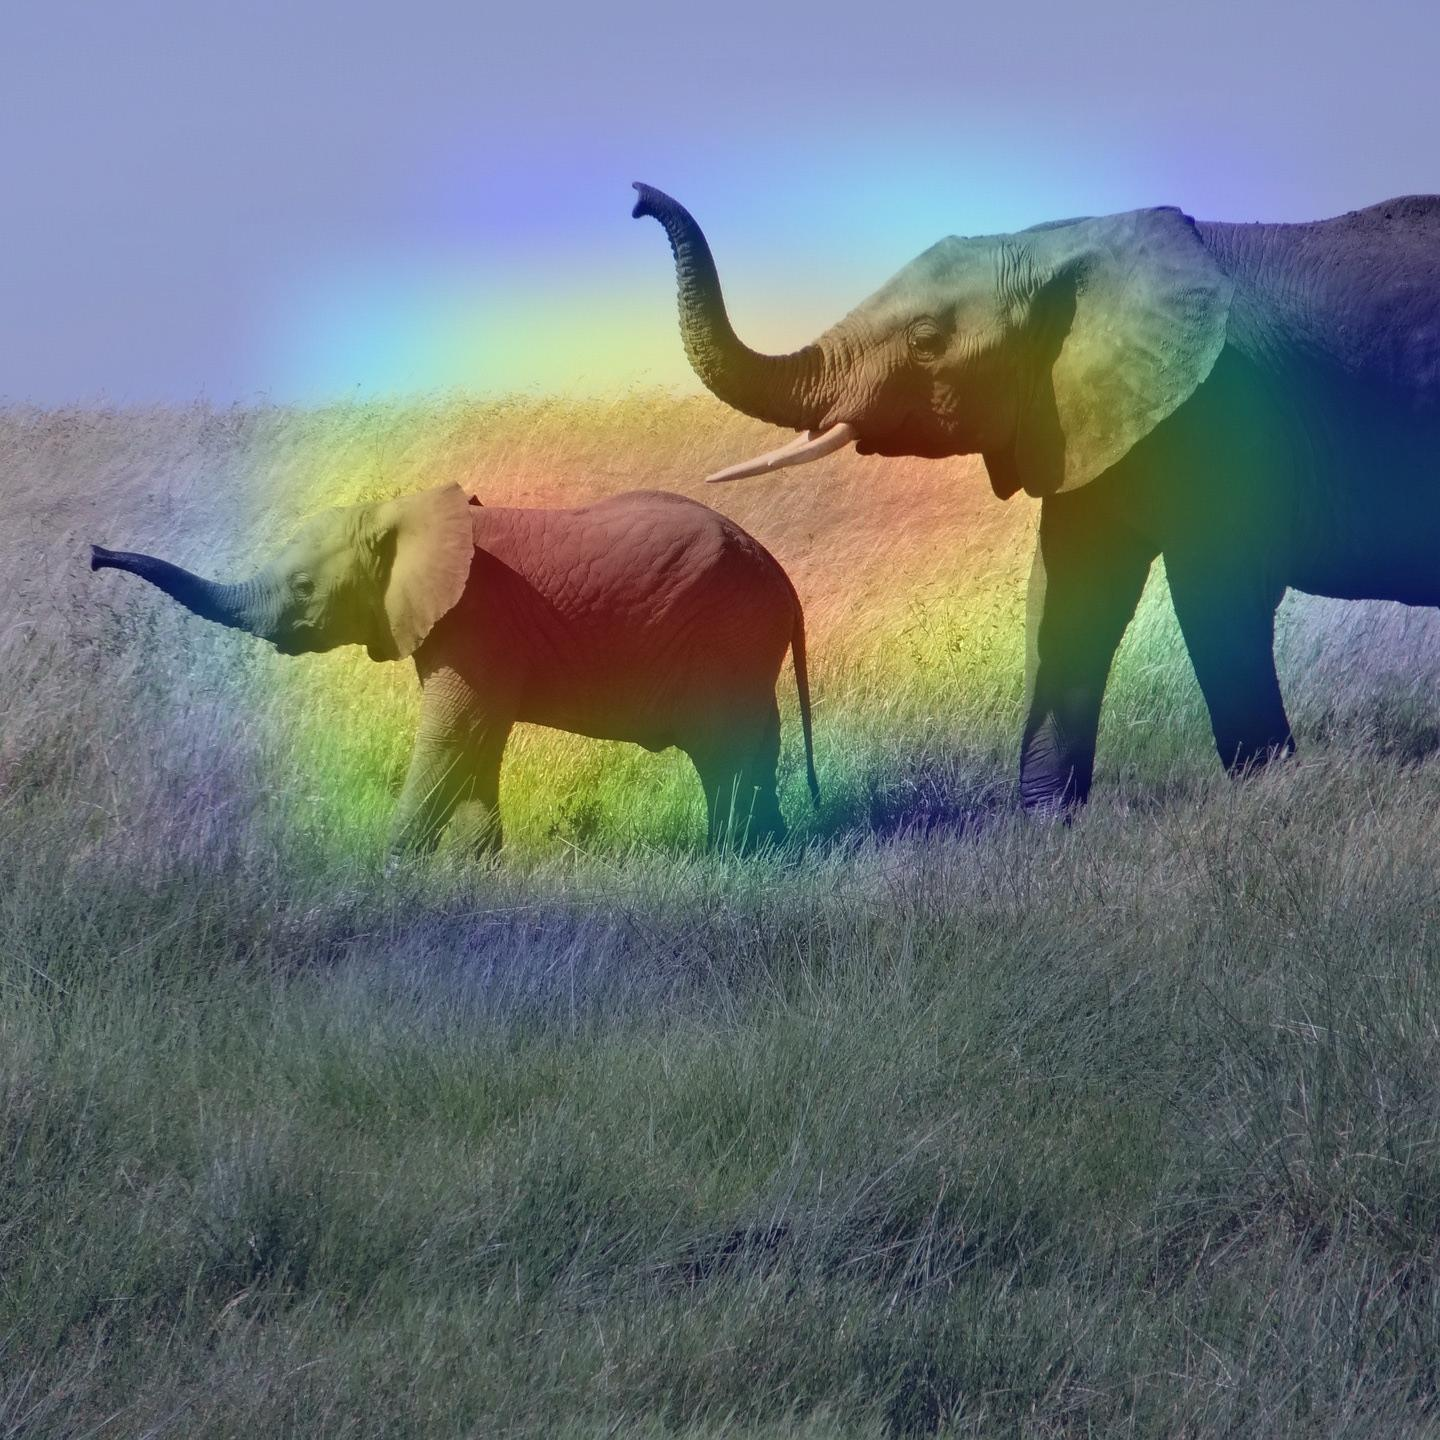

In [ ]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

# rescale
heatmap = np.uint8(255 * heatmap)


jet = plt.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)


save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

display(Image.open(save_path))